In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import math

# Text and feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluation and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc)

# Classifier
from sklearn.naive_bayes import GaussianNB


In [3]:
# Text cleaning & stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

In [5]:
def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
# Stopwords
NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # You can customize this list as needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

In [7]:
def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

In [8]:
def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [35]:
import os
import subprocess
# Choose the project (options: 'pytorch', 'tensorflow', 'keras', 'incubator-mxnet', 'caffe')
project = 'tensorflow' # Change this to run model on different datasets
path = f'/content/drive/MyDrive/{project}.csv'

# Merge Title and Body into a single column; if Body is NaN, use Title only
pd_all = pd.read_csv(path)
pd_all = pd_all.sample(frac=1, random_state=999)
pd_all['Title+Body'] = pd_all.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

# Keep only necessary columns: id, Number, sentiment, text (merged Title+Body)
pd_tplusb = pd_all.rename(columns={
    "Unnamed: 0": "id",
    "class": "sentiment",
    "Title+Body": "text"
})
pd_tplusb.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])

In [36]:
# 1) Data file to read
datafile = 'Title+Body.csv'

# 2) Number of repeated experiments
REPEAT = 10

# 3) Output CSV file name
out_csv_name = f'../{project}_NB.csv'


In [37]:
data = pd.read_csv(datafile).fillna('')
text_col = 'text'


In [38]:
original_data = data.copy()

In [39]:
# Text cleaning
data[text_col] = data[text_col].apply(remove_html)
data[text_col] = data[text_col].apply(remove_emoji)
data[text_col] = data[text_col].apply(remove_stopwords)
data[text_col] = data[text_col].apply(clean_str)

In [40]:
# ========== Hyperparameter grid ==========
# We use logspace for var_smoothing: [1e-12, 1e-11, ..., 1]
params = {
    'var_smoothing': np.logspace(-12, 0, 13)
}


In [64]:
# Lists to store metrics across repeated runs
accuracies  = []
precisions  = []
recalls     = []
f1_scores2   = []
auc_values  = []

for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(data.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = data[text_col].iloc[train_index]
    test_text = data[text_col].iloc[test_index]

    y_train = data['sentiment'].iloc[train_index]
    y_test  = data['sentiment'].iloc[test_index]

    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)

    # --- 4.3 Naive Bayes model & GridSearch ---
    clf = GaussianNB()
    grid = GridSearchCV(
        clf,
        params,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    # Call toarray() to convert to a dense NumPy array before fitting
    grid.fit(X_train.toarray(), y_train)

    # Retrieve the best model
    best_clf = grid.best_estimator_
    # Call toarray() to convert to a dense NumPy array before fitting
    best_clf.fit(X_train.toarray(), y_train)

    # --- 4.4 Make predictions & evaluate ---
    # Call toarray() to convert to a dense NumPy array before predicting
    y_pred = best_clf.predict(X_test.toarray())

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores2.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)
    auc_values.append(auc_val)

In [65]:
# --- 4.5 Aggregate results ---
final_accuracy_baseline  = np.mean(accuracies)
final_precision_baseline = np.mean(precisions)
final_recall_baseline    = np.mean(recalls)
final_f1_baseline       = np.mean(f1_scores2)
final_auc_baseline       = np.mean(auc_values)

print("=== Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy_baseline:.4f}")
print(f"Average Precision:     {final_precision_baseline:.4f}")
print(f"Average Recall:        {final_recall_baseline:.4f}")
print(f"Average F1 score:      {final_f1_baseline:.4f}")
print(f"Average AUC:           {final_auc_baseline:.4f}")


=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.5493
Average Precision:     0.6294
Average Recall:        0.6967
Average F1 score:      0.5322
Average AUC:           0.6967


In [66]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# --- Preprocessing Functions ---
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

stop_words = stopwords.words('english')
custom_stop_words = stop_words + ['...']

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in custom_stop_words])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    return string.strip().lower()

# --- Load and Preprocess Data ---
# the project is tested on 5 datasets which are ---- "incubator-mxnet"  "caffe"  "keras"  "pytorch"  "tensorflow"
project = 'tensorflow'
path = f'/content/drive/MyDrive/{project}.csv'
df = pd.read_csv(path).sample(frac=1, random_state=42)
df['Title+Body'] = df.apply(lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'], axis=1)
df = df.rename(columns={"Unnamed: 0": "id", "class": "sentiment", "Title+Body": "text"})

df['text'] = df['text'].apply(remove_html).apply(remove_emoji).apply(remove_stopwords).apply(clean_str)
df.to_csv('Title+Body.csv', index=False, columns=["id", "Number", "sentiment", "text"])

# --- Prepare for Evaluation ---
data = pd.read_csv('Title+Body.csv').fillna('')
REPEAT = 10
text_col = 'text'

accuracies  = []
precisions  = []
recalls     = []
f1_scores   = []
auc_values  = []

# --- Repeat Training & Evaluation ---
for repeat in range(REPEAT):
    # Split size is 80% training and 20% testing
    indices = np.arange(data.shape[0])
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=repeat)

    train_text = data[text_col].iloc[train_idx]
    test_text  = data[text_col].iloc[test_idx]
    y_train    = data['sentiment'].iloc[train_idx]
    y_test     = data['sentiment'].iloc[test_idx]

    # TF-IDF
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)


# --- Improving the model with the changes shown below ---

    # Oversample with SMOTE
    sm = SMOTE(random_state=repeat)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

    # Model used: Logistic Regression
    clf = LogisticRegression(max_iter=200)
    clf.fit(X_train_resampled, y_train_resampled)

    # Predict
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_values.append(auc(fpr, tpr))

# --- Final Averages Results ---
final_accuracy  = np.mean(accuracies)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("Improved Model using Logistic Regression + TF-IDF + SMOTE:")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Improved Model using Logistic Regression + TF-IDF + SMOTE:
Number of repeats:     10
Average Accuracy:      0.8664
Average Precision:     0.7831
Average Recall:        0.8307
Average F1 score:      0.8018
Average AUC:           0.9228


In [71]:
from scipy.stats import ttest_rel

# Performing paired t-test by getting f1 scores from the basline and the improved model
t_statistic, p_value = ttest_rel(f1_scores2, f1_scores)

# Displaying the results
print(f"Paired t-test results:")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Statistically significant improvement (p < 0.05)")
else:
    print("No statistically significant difference (p ≥ 0.05)")


Paired t-test results:
t-statistic: -36.1598
p-value: 0.0000
Statistically significant improvement (p < 0.05)


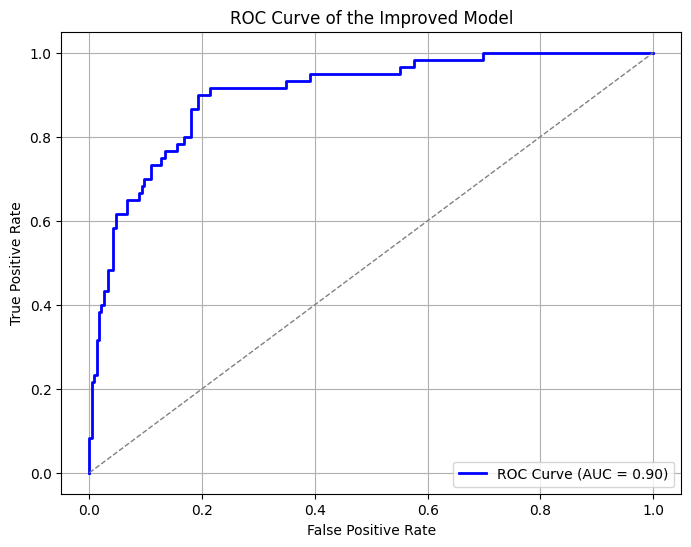

In [72]:
import matplotlib.pyplot as plt
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the Improved Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

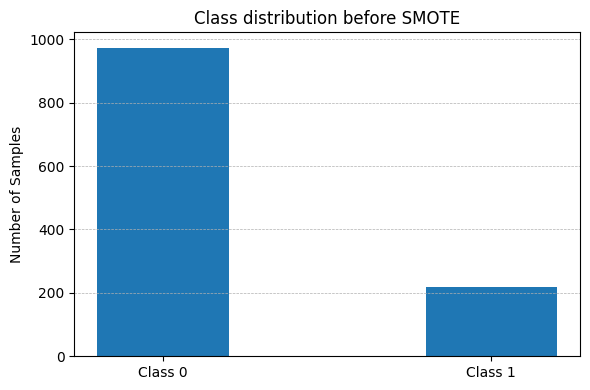

In [73]:
import matplotlib.pyplot as plt
from collections import Counter

# original class distribution from y_train
original_class_dist = Counter(y_train)
labels = sorted(original_class_dist.keys())
counts = [original_class_dist[l] for l in labels]

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, width=0.4)

plt.xticks(labels, [f'Class {l}' for l in labels])
plt.ylabel('Number of Samples')
plt.title('Class distribution before SMOTE')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


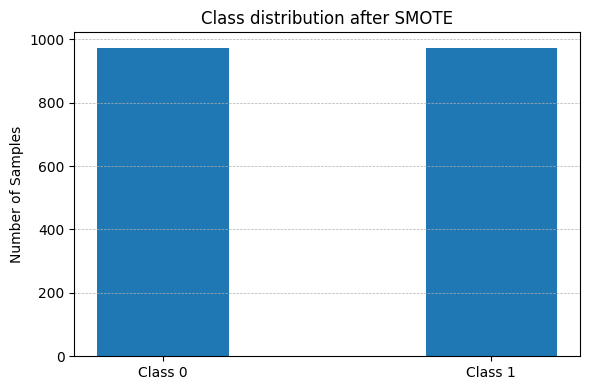

In [74]:
# Count class distribution after SMOTE
resampled_class_dist = Counter(y_train_resampled)
labels = sorted(resampled_class_dist.keys())
counts = [resampled_class_dist[l] for l in labels]

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, width=0.4)

plt.xticks(labels, [f'Class {l}' for l in labels])
plt.ylabel('Number of Samples')
plt.title('Class distribution after SMOTE')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


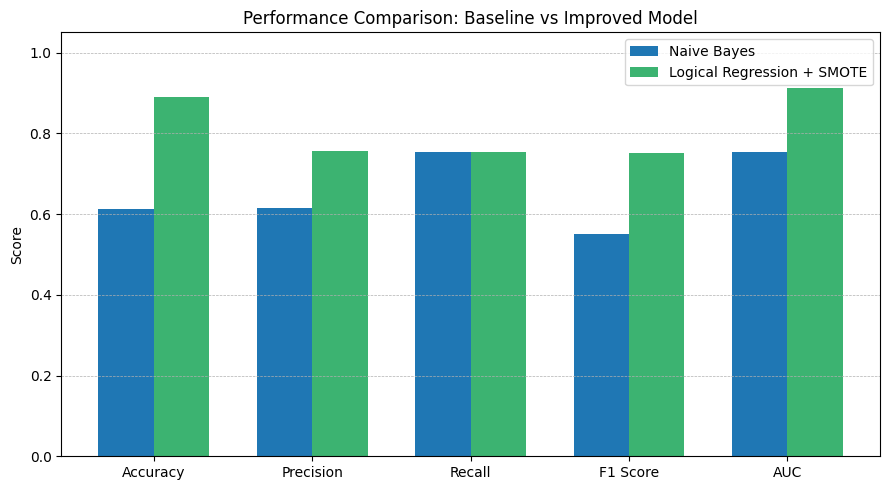

In [73]:


import matplotlib.pyplot as plt
import numpy as np

# Metric values from running the basline model and the improved model
baseline_metrics = {
    'Accuracy': final_accuracy_baseline,
    'Precision': final_precision_baseline,
    'Recall': final_recall_baseline,
    'F1 Score': final_f1_baseline,
    'AUC': final_auc_baseline
}

improved_metrics = {
    'Accuracy': final_accuracy,
    'Precision': final_precision,
    'Recall': final_recall,
    'F1 Score': final_f1,
    'AUC': final_auc
}

# Labels and values for the basline vs the improved model
labels = list(baseline_metrics.keys())
baseline_scores = [baseline_metrics[k] for k in labels]
improved_scores = [improved_metrics[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

# Plotting the bar chart
plt.figure(figsize=(9, 5))
plt.bar(x - width/2, baseline_scores, width, label='Naive Bayes')
plt.bar(x + width/2, improved_scores, width, label='Logical Regression + SMOTE', color='mediumseagreen')

plt.xticks(x, labels)
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('Performance Comparison: Baseline vs Improved Model')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [79]:
import os

# Combine results into a  raw df
results_df = pd.DataFrame({
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC': auc_values
})

# Append mean row at the bottom
mean_score = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1 Score': np.mean(f1_scores),
    'AUC': np.mean(auc_values)
}
results_df.loc['Mean'] = mean_score

# Save to Google Drive automatically
output_path = f'/content/drive/MyDrive/{project}_results_improved.csv'
results_df.to_csv(output_path)
